In [1]:
import os

import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm
import statannot as sa

from lib.data import raw_io as io
from lib.data import processed_io as pio
from lib.data import conditions as cond
from lib.features import decomposition as de

In [2]:
np.random.seed(42)

In [3]:
DATA_PATH = os.path.join('..', 'data', 'processed', 'trials_by_celltype')

In [4]:
raw_data_by_day = {
    day: pio.load_sessions_by_day(DATA_PATH, day, catch_behaviour='exclude') for day in cond.DAYS
}

In [5]:
def get_mean_fluorescence_by_cell_type(daily_data: io.SessionTrials):
    mean_fluorescence = {}
    for cell_type in daily_data.keys():

        # Concatenate fluorescence of each mouse
        mean_fluorescence[cell_type] = daily_data[cell_type][0].fluo.trial_mean()
        
        # Transfer meta attributes from SessionTrials to LongFluorescence
        mean_fluorescence[cell_type].set_meta_attr('mouse_id', daily_data[cell_type][0].mouse_id)
        mean_fluorescence[cell_type].set_meta_attr('day', daily_data[cell_type][0].day)
        mean_fluorescence[cell_type].set_meta_attr('cell_type', daily_data[cell_type][0].cell_type)
            
        for i in range(1, len(daily_data[cell_type])):
            trial_mean_fluo = daily_data[cell_type][i].fluo.trial_mean()
            
            # Transfer meta attributes from SessionTrials to LongFluorescence
            trial_mean_fluo.set_meta_attr('mouse_id', daily_data[cell_type][i].mouse_id)
            trial_mean_fluo.set_meta_attr('day', daily_data[cell_type][i].day)
            trial_mean_fluo.set_meta_attr('cell_type', daily_data[cell_type][i].cell_type)
            
            mean_fluorescence[cell_type].append(
                trial_mean_fluo
            )
            del trial_mean_fluo

        print('Got {} {} cells'.format(mean_fluorescence[cell_type].fluo.shape[0], cell_type))
        mean_fluorescence[cell_type].remove_nan()
    
    return mean_fluorescence

In [6]:
mean_fluorescence_by_day = {
    day: get_mean_fluorescence_by_cell_type(raw_data_by_day[day]) 
    for day in raw_data_by_day.keys()
}

Got 1209 pyr cells
Got 189 som cells
Got 252 pv cells
Got 407 vip cells
Got 1462 pyr cells
Got 207 som cells
Got 285 pv cells
Got 487 vip cells
Got 1730 pyr cells
Got 236 som cells
Got 305 pv cells
Got 513 vip cells
Got 1848 pyr cells
Got 250 som cells
Got 340 pv cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 2 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (420) and other (435) do not match, 15 excess frames will be trimmed from the end of other
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 4 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (428) and other (420) do not match, 8 excess frames will be trimmed from the end of self
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 6 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 3 all-nan 

Got 534 vip cells
Got 1919 pyr cells
Got 276 som cells
Got 350 pv cells
Got 534 vip cells
Got 2026 pyr cells
Got 284 som cells
Got 354 pv cells
Got 562 vip cells
Got 2098 pyr cells
Got 318 som cells
Got 362 pv cells
Got 565 vip cells


/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:822: UserWarning: Removing 7 all-nan rows
  warnings.warn(
/Users/efharkin/Documents/projects/chen-lab/interneuron-reward/src/data/raw_io.py:765: ShapeWarning: `num_frames` in self (420) and other (438) do not match, 18 excess frames will be trimmed from the end of other
  warnings.warn(


In [7]:
def aggregate_fluorescence(daily_data, num_frames_to_keep=390):
    meta = []
    fluo_matrices = []
    for cell_type in cond.CellType:
        meta.append(daily_data[cell_type]._meta)
        fluo_matrices.append(daily_data[cell_type].fluo)

    min_num_frames = np.min([fl.shape[1] for fl in fluo_matrices])
    assert min_num_frames >= num_frames_to_keep

    meta = pd.concat(meta, ignore_index=True)
    meta.reset_index(inplace=True)
    
    grand_fluo = io.LongFluorescence(
        0, 
        meta['cell_num'], 
        np.concatenate([fl[:, :num_frames_to_keep] for fl in fluo_matrices])
    )
    
    meta['cell_uid'] = meta['mouse_id'] + '_' + meta['cell_type'].astype(str) + '_' + meta['cell_num'].astype(str)
    grand_fluo._meta = meta

    return grand_fluo

In [8]:
grand_fluo_by_day = {day: aggregate_fluorescence(mean_fluorescence_by_day[day]) for day in cond.DAYS}

In [9]:
grand_fluo_by_day[min(cond.DAYS)].get_meta_attr('cell_type')[10]

CellType.pyr

In [10]:
grand_fluo = grand_fluo_by_day[cond.DAYS[0]]

for day in cond.DAYS[1:]:
    grand_fluo.append(grand_fluo_by_day[day])

In [11]:
first_day = []
known_first_days = {}

for uid in tqdm(grand_fluo.get_meta_attr('cell_uid')):
    maybe_first_day = known_first_days.get(uid, False)
    if not maybe_first_day:
        first_day_this_uid = min(
            grand_fluo.get_meta_attr('day')[
                grand_fluo.get_meta_attr('cell_uid') == uid
            ]
        )
        known_first_days[uid] = first_day_this_uid
        first_day.append(first_day_this_uid)
    else:
        first_day.append(maybe_first_day)

grand_fluo.set_meta_attr('first_day', first_day)

del first_day, known_first_days

100%|██████████| 19814/19814 [00:04<00:00, 4437.65it/s] 


In [12]:
day7_pca = PCA(random_state=42)
day7_pca.fit(grand_fluo.fluo[grand_fluo.get_meta_attr('day') == max(cond.DAYS), :])
projections = day7_pca.transform(grand_fluo.fluo)

Text(0.5, 0, 'Component no.')

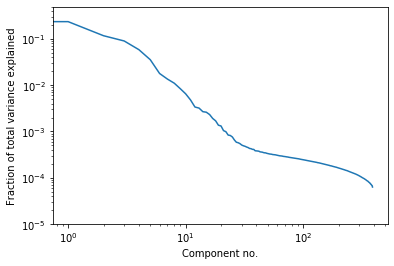

In [13]:
plt.loglog(day7_pca.explained_variance_ratio_)
plt.ylim(1e-5, 0.5)
plt.ylabel('Fraction of total variance explained')
plt.xlabel('Component no.')

In [14]:
day7_pca.components_.shape

(390, 390)

In [15]:
trial_structure = de.TrialBasisFunctions(390, tone_duration=1.0, delay_duration=1.5, reward_duration=2.5)

In [16]:
basis_similarities = {
    'tone': [
        de.cos_similarity(trial_structure.tone, day7_pca.components_[i, :]) 
        for i in range(390)
    ],
    'tone + delay': [
        de.cos_similarity(trial_structure.tone + trial_structure.delay, day7_pca.components_[i, :]) 
        for i in range(390)
    ],
    'reward': [
        de.cos_similarity(trial_structure.reward, day7_pca.components_[i, :]) 
        for i in range(390)
    ]
}

In [17]:
num_components = 50

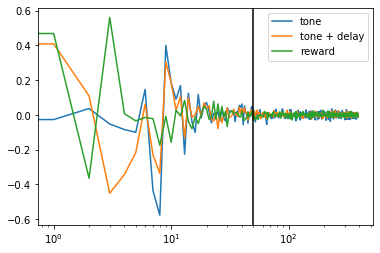

In [18]:
for trial_component in basis_similarities:
    plt.semilogx(basis_similarities[trial_component], label=trial_component)
plt.axvline(num_components, color='k')
plt.legend()

In [31]:
basis_projections = {
    'tone': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.tone),
    'tone + delay': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.tone + trial_structure.delay),
    'delay': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.delay),
    'reward': de.ols(day7_pca.components_[:num_components, :].T, trial_structure.reward),
}

In [36]:
np.arccos(de.cos_similarity(basis_projections['delay'], basis_projections['tone + delay'])) / np.pi * 180.

41.61478325207611

In [44]:
def angle(a, b):
    return np.arccos(de.cos_similarity(a, b)) / np.pi * 180.

In [48]:
sum_of_angles = (
    180. - angle(basis_projections['tone'], basis_projections['delay']) 
    + angle(basis_projections['tone'], basis_projections['tone + delay'])
    + angle(basis_projections['delay'], basis_projections['tone + delay'])
)
sum_of_angles

180.0

In [51]:
180 - angle(basis_projections['delay'], basis_projections['tone'])

84.64918581513561

In [38]:
basis_projections['tone'] + basis_projections['delay']

array([-1.14174872,  3.2198818 ,  0.56364912, -4.13764827, -2.53128463,
       -1.64172997,  0.02958995, -1.49750564, -2.21511727,  2.24540977,
        1.35221817,  0.18016556,  0.8613675 , -1.00168079,  0.85318954,
       -0.08769948,  0.06689313,  0.36426663,  0.01803524,  0.43233807,
        0.18508852,  0.37571823, -0.26130267, -0.27821594,  0.11105271,
       -0.66342786,  0.01466836, -0.43462249,  0.10589442, -0.26445518,
        0.20736824, -0.15701687, -0.25422053, -0.26590793,  0.25877867,
       -0.01124761, -0.0081409 , -0.11471034,  0.31612551,  0.23291254,
        0.16919185,  0.30497646,  0.1479368 ,  0.2493154 , -0.12933278,
       -0.34720585,  0.4303992 ,  0.17639458, -0.12518758, -0.03997373])

In [41]:
np.isclose(basis_projections['tone + delay'], (basis_projections['tone'] + basis_projections['delay']))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [52]:
ideal_projection_similarities = {}

for trial_component in basis_projections.keys():
    ideal_projection_similarities[trial_component] = np.array([
        de.cos_similarity(projections[i, :num_components], basis_projections[trial_component])
        for i in range(projections.shape[0])
    ])

In [56]:
from scipy import stats

In [58]:
mask = (grand_fluo.get_meta_attr('day') == max(cond.DAYS))
stats.spearmanr(ideal_projection_similarities['tone'][mask], ideal_projection_similarities['reward'][mask])

SpearmanrResult(correlation=-0.2550976416427857, pvalue=1.4092366064599358e-50)

In [61]:
np.outer(mask, trial_structure.tone).shape

(19814, 390)

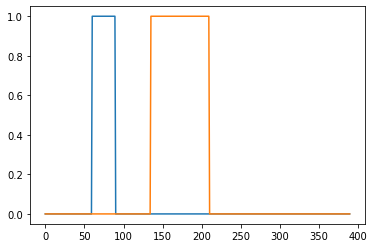

In [68]:
plt.plot(trial_structure.tone)
plt.plot(trial_structure.reward)

In [67]:
stats.spearmanr(grand_fluo.fluo[:, trial_structure.tone].mean(axis=1)[mask], 
grand_fluo.fluo[:, trial_structure.reward].mean(axis=1)[mask])

SpearmanrResult(correlation=-0.05802469167341906, pvalue=0.0008126885471494804)

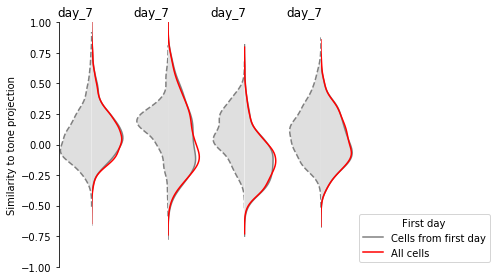

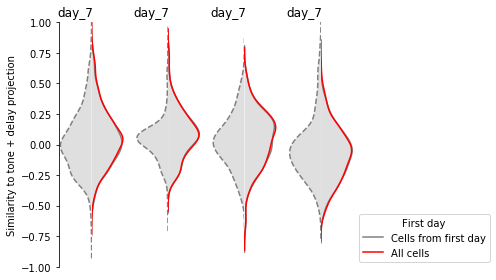

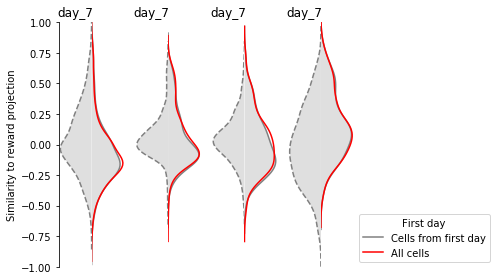

In [21]:
spec = gs.GridSpec(1, len(cond.CellType))

for condition in ideal_projection_similarities:
    plt.figure(figsize=(7, 4))
    for i, celltype in enumerate(cond.CellType):
        sub_spec = gs.GridSpecFromSubplotSpec(1, 2, spec[0, i], wspace=0)
        
        plt.subplot(sub_spec[:, 0])
        plt.title(str(day))
        mask = (
            (grand_fluo.get_meta_attr('cell_type') == celltype) 
            & (grand_fluo.get_meta_attr('day') == min(cond.DAYS))
        )
        sns.kdeplot(
            ideal_projection_similarities[condition][mask], 
            vertical=True, shade=True, ls='--', color='gray', label='any'
        )
        plt.gca().invert_xaxis()
        plt.xticks([])
        plt.ylim(-1, 1)
        plt.gca().get_legend().remove()
        
        if i == 0:
            plt.ylabel('Similarity to {} projection'.format(condition))
            sns.despine(ax=plt.gca(), top=True, right=True, bottom=True)
        else:
            plt.yticks([])
            sns.despine(ax=plt.gca(), top=True, left=True, bottom=True, right=True)

            
        plt.subplot(sub_spec[:, 1])
        mask = (
            (grand_fluo.get_meta_attr('cell_type') == celltype) 
            & (grand_fluo.get_meta_attr('day') == day)
            & (grand_fluo.get_meta_attr('first_day') == min(cond.DAYS))
        )
        sns.kdeplot(
            ideal_projection_similarities[condition][mask], 
            vertical=True, shade=True, color='gray', label='Cells from first day'
        )
        
        mask = (
            (grand_fluo.get_meta_attr('cell_type') == celltype) 
            & (grand_fluo.get_meta_attr('day') == day)
        )
        sns.kdeplot(
            ideal_projection_similarities[condition][mask], 
            vertical=True, shade=False, color='red', label='All cells'
        )
        
        sns.despine(ax=plt.gca(), top=True, left=True, bottom=True, right=True)

        plt.xticks([])
        plt.ylim(-1, 1)
        plt.yticks([])

        if i == len(cond.CellType) - 1:
            plt.legend(title='First day', loc='lower left', bbox_to_anchor=(1, 0))
        else:
            plt.gca().get_legend().remove()
            

    plt.tight_layout()
    #plt.savefig('../img/response_patterns_by_first_day/{}_{}.png'.format(celltype, condition), dpi=290)
    plt.show()

In [22]:
df = grand_fluo._meta.copy()
for key in ideal_projection_similarities:
    df[key] = ideal_projection_similarities[key]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

som_day_1 v.s. som_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.263e-04 U_stat=2.198e+04
pyr_day_1 v.s. pyr_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.816e-08 U_stat=6.302e+05
pv_day_1 v.s. pv_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.126e-29 U_stat=4.900e+04
vip_day_1 v.s. vip_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.305e-06 U_stat=9.846e+04


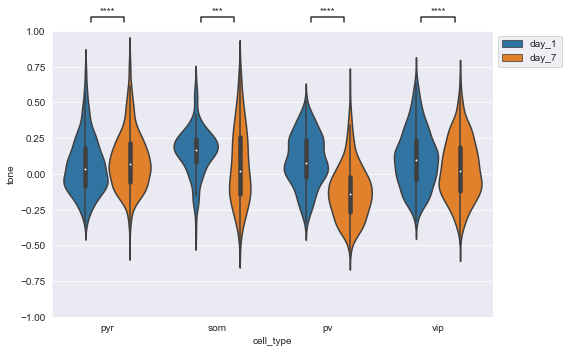

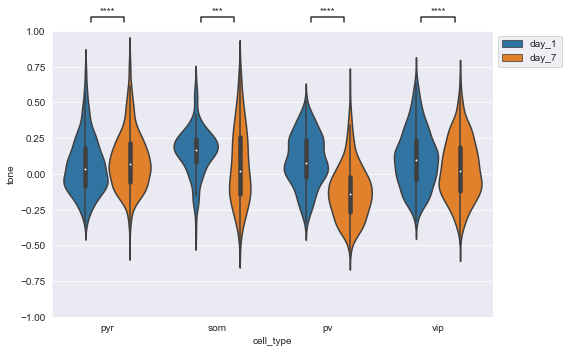

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

som_day_1 v.s. som_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.788e-03 U_stat=1.442e+04
pyr_day_1 v.s. pyr_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.184e-05 U_stat=6.555e+05
pv_day_1 v.s. pv_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.311e-01 U_stat=2.874e+04
vip_day_1 v.s. vip_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.063e-01 U_stat=8.721e+04


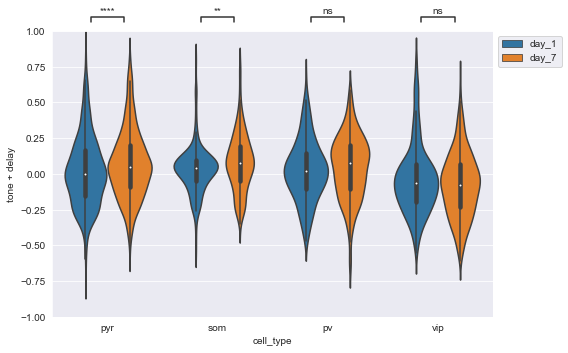

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

som_day_1 v.s. som_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.638e-01 U_stat=1.981e+04
pyr_day_1 v.s. pyr_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.235e-27 U_stat=9.171e+05
pv_day_1 v.s. pv_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.266e-02 U_stat=3.517e+04
vip_day_1 v.s. vip_day_7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.118e-16 U_stat=5.441e+04


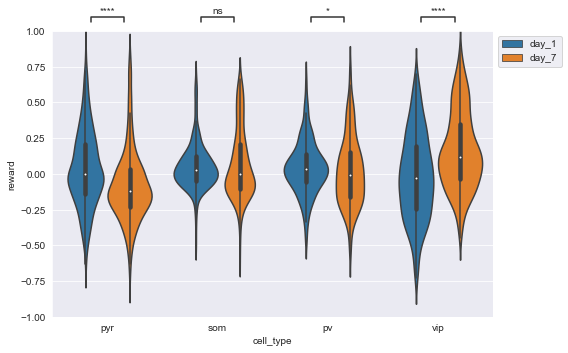

In [24]:
sns.set_style('darkgrid')

for key in ideal_projection_similarities:
    plt.figure(figsize=(8, 5))
    ax = plt.subplot(111)

    sns.violinplot(
        'cell_type', key, 'day', 
        data=df.loc[[(day in (cond.Day(1), cond.Day(7))) for day in df['day']], :],
        ax=ax
    )
    plt.ylim(-1, 1)

    sa.add_stat_annotation(
        ax, 
        x='cell_type', y=key, hue='day', 
        data=df.loc[
            np.array([(day in (cond.Day(1), cond.Day(7))) for day in df['day']]) 
            & np.array([first_day == cond.Day(1) for first_day in df['first_day']]), 
            :
        ],
        box_pairs=[
            ((cell_type, cond.Day(1)), (cell_type, cond.Day(7)))
            for cell_type in cond.CellType
        ],
        comparisons_correction='bonferroni',
        test='Mann-Whitney',
        loc='outside'
    )

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    
    plt.savefig('../img/response_violins/{}.png'.format(key), dpi=600)
    plt.show()

# Histograms

In [25]:
def learning_quiver(x, y, units, first_timestep, bins=20):
    x = np.asarray(x)
    y = np.asarray(y)
    units = np.asarray(units)
    timestep_mask = np.asarray(first_timestep)
    assert len(x) == len(y)
    assert len(x) == len(units)
    assert len(x) == len(first_timestep)
    
    x_bin_edges = np.linspace(x.min(), x.max(), bins + 1)
    y_bin_edges = np.linspace(y.min(), y.max(), bins + 1)
    
    x_starts = []
    y_starts = []
    x_ends = []
    y_ends = []
    count = []
    for i in range(bins):
        for j in range(bins):
            start_mask = (
                (x >= x_bin_edges[i]) 
                & (x < x_bin_edges[i + 1])
                & (y >= y_bin_edges[j])
                & (y < y_bin_edges[j + 1])
                & first_timestep
            )
            count.append(np.sum(start_mask))
            units_in_start_bin = units[start_mask]
            end_mask = [
                (uid in units_in_start_bin) and not timestep
                for timestep, uid in zip(first_timestep, units) 
            ]
            x_starts.append(x[start_mask].mean())
            y_starts.append(y[start_mask].mean())
            x_ends.append(x[end_mask].mean() - x_starts[-1])
            y_ends.append(y[end_mask].mean() - y_starts[-1])
            
    plt.quiver(x_starts, y_starts, x_ends, y_ends, count, angles='xy', scale_units='xy', scale=None)

In [26]:
def learning_quiver_by_condition(cell_type, first_day, last_day, x_component, y_component, flip_time=False):
    mask = (
        (grand_fluo.get_meta_attr('cell_type') == cell_type) 
        & (grand_fluo.get_meta_attr('first_day') <= min(first_day, last_day))
        & ((grand_fluo.get_meta_attr('day') == first_day) 
           | (grand_fluo.get_meta_attr('day') == last_day))
    )
    if not flip_time:
        first_timestep_mask = grand_fluo.get_meta_attr('day')[mask] == first_day
    else:
        first_timestep_mask = grand_fluo.get_meta_attr('day')[mask] == last_day
    learning_quiver(
        x=ideal_projection_similarities[x_component][mask], 
        y=ideal_projection_similarities[y_component][mask],
        units=grand_fluo.get_meta_attr('cell_uid')[mask],
        first_timestep=first_timestep_mask,
        bins=7
    )

<ipython-input-25-156a9f97cb88>:33: RuntimeWarning: Mean of empty slice.
  x_starts.append(x[start_mask].mean())
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-25-156a9f97cb88>:34: RuntimeWarning: Mean of empty slice.
  y_starts.append(y[start_mask].mean())
<ipython-input-25-156a9f97cb88>:35: RuntimeWarning: Mean of empty slice.
  x_ends.append(x[end_mask].mean() - x_starts[-1])
<ipython-input-25-156a9f97cb88>:36: RuntimeWarning: Mean of empty slice.
  y_ends.append(y[end_mask].mean() - y_starts[-1])
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/matplotlib/quiver.py:748: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/opt/miniconda3/envs/candice/lib/python3.8/site-packages/matplotlib/quiver.py:762: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minl

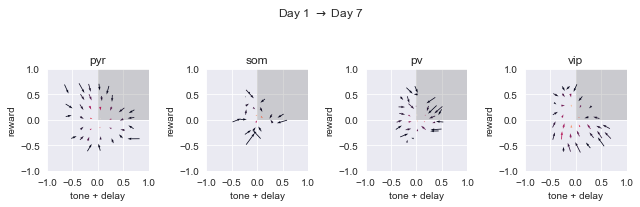

In [27]:
plt.figure(figsize=(9, 3))
plt.suptitle(r'Day 1 $\rightarrow$ Day 7')

for i, celltype in enumerate(cond.CellType):
    
    plt.subplot(1, len(cond.CellType), i+1)
    plt.title(celltype)
    plt.gca().set_aspect(1)
    plt.fill_between(
        [0, 1], [0, 0], [1, 1], 
        facecolor='gray', alpha=0.3, edgecolor='none',
        label='Captured by reliability analysis'
    )
    learning_quiver_by_condition(
        celltype, cond.Day(1), cond.Day(7), 'tone + delay', 'reward'
    )
    plt.xlabel('tone + delay')
    plt.ylabel('reward')
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xticks([-1, -0.5, 0, 0.5, 1])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.savefig('../img/quiver/all_celltypes_not_to_scale.png'.format(celltype), dpi=600)

plt.show()


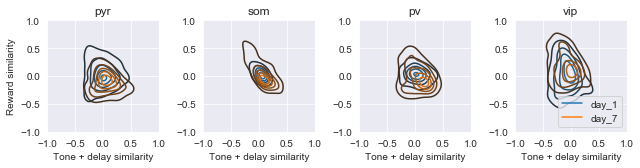

In [28]:
def mask(cell_type, first_day, day):
    mask = (
        (grand_fluo.get_meta_attr('cell_type') == cell_type) 
        & (grand_fluo.get_meta_attr('first_day').apply(hash) == first_day)
        & (grand_fluo.get_meta_attr('day').apply(hash) == day)
    )
    return mask

days_to_plot = {
    'left': min(cond.DAYS),
    'right': max(cond.DAYS)
}
gridsize=(7)

plt.figure(figsize=(9, 3))

for i, cell_type in enumerate(cond.CellType):

    plt.subplot(1, len(cond.CellType), i+1)
    plt.title(cell_type)
    plt.gca().set_aspect(1)
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    sns.kdeplot(
        ideal_projection_similarities['tone + delay'][mask(cell_type, min(cond.DAYS), days_to_plot['left'])],
        ideal_projection_similarities['reward'][mask(cell_type, min(cond.DAYS), days_to_plot['left'])],
        n_levels=5,
        label=str(days_to_plot['left'])
    )
    sns.kdeplot(
        ideal_projection_similarities['tone + delay'][mask(cell_type, min(cond.DAYS), days_to_plot['right'])],
        ideal_projection_similarities['reward'][mask(cell_type, min(cond.DAYS), days_to_plot['right'])],
        n_levels=5,
        label=str(days_to_plot['right'])
    )
    plt.xlabel('Tone + delay similarity')
    if i == 0:
        plt.ylabel('Reward similarity')
    plt.xticks([-1, -0.5, 0, 0.5, 1])

plt.legend(loc='lower right')
    
plt.tight_layout()

plt.savefig('../img/joint_response_patterns/all_cells.png'.format(cell_type), dpi=290)

In [29]:
def mask(first_day, days):
    mask = (
        (grand_fluo.get_meta_attr('first_day').apply(hash) == first_day)
        & np.isin(grand_fluo.get_meta_attr('day').apply(hash), days)
    )
    return mask

In [30]:
pivoted = (
    df
    .loc[mask(min(cond.DAYS), cond.DAYS), :]
    .pivot(index='cell_uid', columns='day', values=['reward', 'tone + delay', 'cell_type'])
)

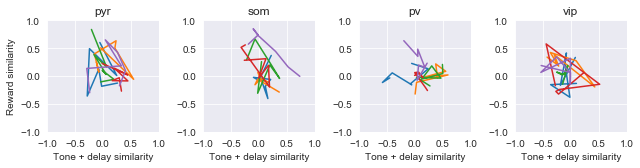

In [31]:
plt.figure(figsize=(9, 3))

for i, cell_type in enumerate(cond.CellType):

    tmp = pivoted.loc[pivoted['cell_type'][cond.Day(1)] == cell_type, ['reward', 'tone + delay']]
    probs = np.linalg.norm(
        np.array([tmp['reward'][cond.Day(7)], tmp['tone + delay'][cond.Day(7)]]).astype(np.float64), 
        axis=0
    )
    rows = np.random.choice(np.arange(tmp.shape[0]), size=5, replace=False, p=np.nan_to_num(probs) / np.nansum(probs))

    plt.subplot(1, len(cond.CellType), i+1)
    plt.title(cell_type)
    plt.gca().set_aspect(1)
    
    plt.plot(tmp['tone + delay'].iloc[rows, :].to_numpy().T, tmp['reward'].iloc[rows, :].to_numpy().T)
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xticks([-1, -0.5, 0, 0.5, 1])
    
    plt.xlabel('Tone + delay similarity')
    if i == 0:
        plt.ylabel('Reward similarity')
    
plt.tight_layout()
plt.savefig('../img/joint_response_patterns/sample_trajectories.png', dpi=600)